# Forecasting with Prophet

In [3]:
# load libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

In [4]:
# load data
filepath = "https://raw.githubusercontent.com/hiydavid/time-series/main/data/PJME_hourly.csv"
pjme = pd.read_csv(filepath, index_col=[0], parse_dates=[0])
pjme.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 145366 entries, 2002-12-31 01:00:00 to 2018-01-02 00:00:00
Data columns (total 1 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   PJME_MW  145366 non-null  float64
dtypes: float64(1)
memory usage: 2.2 MB


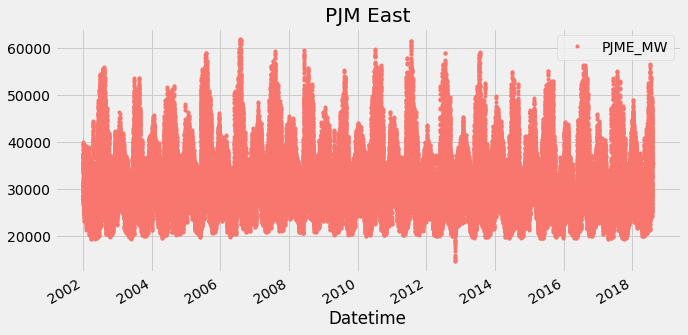

In [5]:
# plot time series
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
pjme.plot(style='.', figsize=(10,5), color=color_pal[0], title='PJM East')
plt.show()

In [14]:
# function to create features
def create_features(df, label=None):
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.isocalendar().week
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

X, y = create_features(pjme, label='PJME_MW')

features_and_target = pd.concat([X, y], axis=1)

features_and_target.head()

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,PJME_MW
Datetime,,,,,,,,,
2002-12-31 01:00:00,1,1,4,12,2002,365,31,1,26498.0
2002-12-31 02:00:00,2,1,4,12,2002,365,31,1,25147.0
2002-12-31 03:00:00,3,1,4,12,2002,365,31,1,24574.0
2002-12-31 04:00:00,4,1,4,12,2002,365,31,1,24393.0
2002-12-31 05:00:00,5,1,4,12,2002,365,31,1,24860.0


In [10]:
# set train vs test
split_date = '01-Jan-2015'
pjme_train = pjme.loc[pjme.index <= split_date].copy()
pjme_test = pjme.loc[pjme.index > split_date].copy()

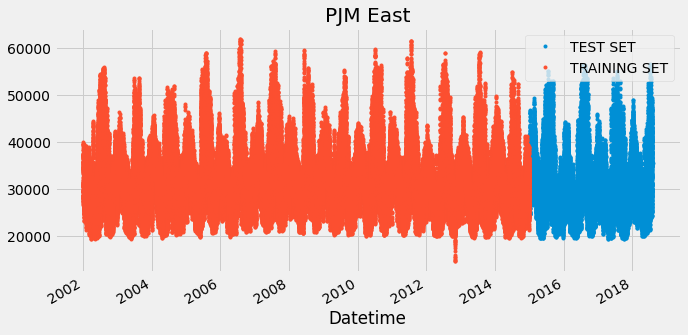

In [11]:
# plot train and test so you can see where we have split
pjme_test \
    .rename(columns={'PJME_MW': 'TEST SET'}) \
    .join(pjme_train.rename(columns={'PJME_MW': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(10,5), title='PJM East', style='.')
plt.show()

In [12]:
# format data for prophet model using ds and y
pjme_train.reset_index().rename(columns={'Datetime':'ds', 'PJME_MW':'y'}).head()

,ds,y
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


In [13]:
# train model and fit
model = Prophet()
model.fit(pjme_train.reset_index().rename(columns={'Datetime':'ds', 'PJME_MW':'y'}))

DEBUG:cmdstanpy:input tempfile: /tmp/tmpq5q_7wsv/z5nhy9bq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq5q_7wsv/dgi_72zd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40657', 'data', 'file=/tmp/tmpq5q_7wsv/z5nhy9bq.json', 'init=/tmp/tmpq5q_7wsv/dgi_72zd.json', 'output', 'file=/tmp/tmpqv5pgo2e/prophet_model-20220724162712.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:27:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:29:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [15]:
# predict on training set with model
pjme_test_fcst = model.predict(df=pjme_test.reset_index().rename(columns={'Datetime':'ds'}))
pjme_test_fcst.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-01 01:00:00,31210.697022,24052.073890,32801.950723,31210.697022,31210.697022,-2862.203082,-2862.203082,-2862.203082,-4430.342550,...,1281.401225,1281.401225,1281.401225,286.738243,286.738243,286.738243,0.0,0.0,0.0,28348.493940
1,2015-01-01 02:00:00,31210.659947,22189.956520,31536.810525,31210.659947,31210.659947,-4366.556573,-4366.556573,-4366.556573,-5927.229009,...,1272.643174,1272.643174,1272.643174,288.029261,288.029261,288.029261,0.0,0.0,0.0,26844.103373
2,2015-01-01 03:00:00,31210.622871,21650.728951,30690.161736,31210.622871,31210.622871,-5238.271879,-5238.271879,-5238.271879,-6790.313052,...,1262.679362,1262.679362,1262.679362,289.361810,289.361810,289.361810,0.0,0.0,0.0,25972.350992
3,2015-01-01 04:00:00,31210.585796,21385.719236,30289.110295,31210.585796,31210.585796,-5379.878306,-5379.878306,-5379.878306,-6922.247590,...,1251.633368,1251.633368,1251.633368,290.735916,290.735916,290.735916,0.0,0.0,0.0,25830.707490
4,2015-01-01 05:00:00,31210.548721,22094.750447,31173.279053,31210.548721,31210.548721,-4705.597210,-4705.597210,-4705.597210,-6237.389790,...,1239.640977,1239.640977,1239.640977,292.151603,292.151603,292.151603,0.0,0.0,0.0,26504.951510


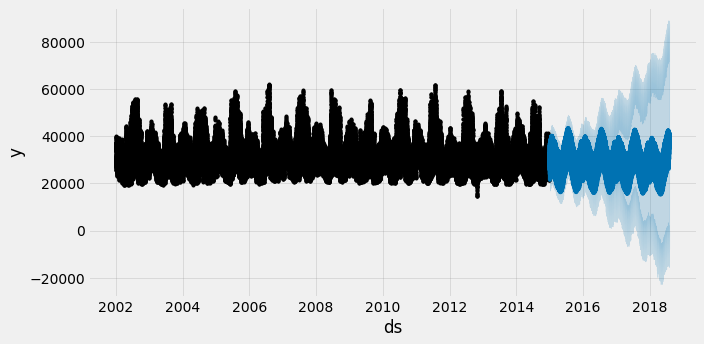

In [16]:
# plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
fig = model.plot(pjme_test_fcst, ax=ax)
plt.show()

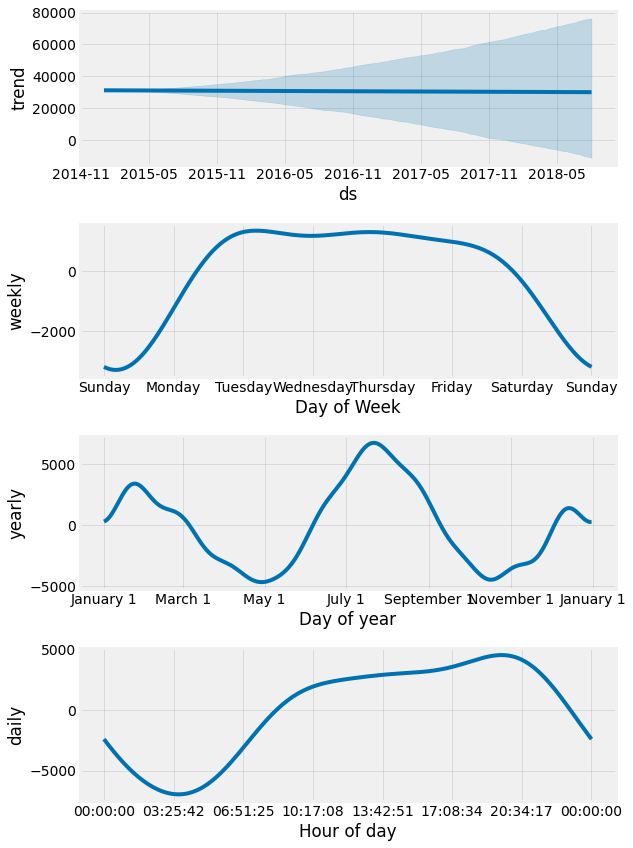

In [17]:
# plot the components of the model
fig = model.plot_components(pjme_test_fcst)

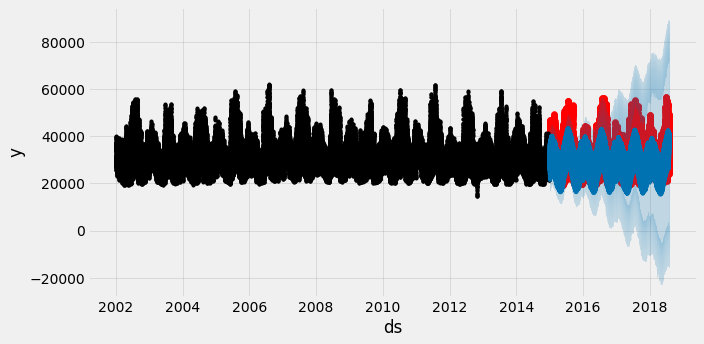

In [18]:
# plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')
fig = model.plot(pjme_test_fcst, ax=ax)

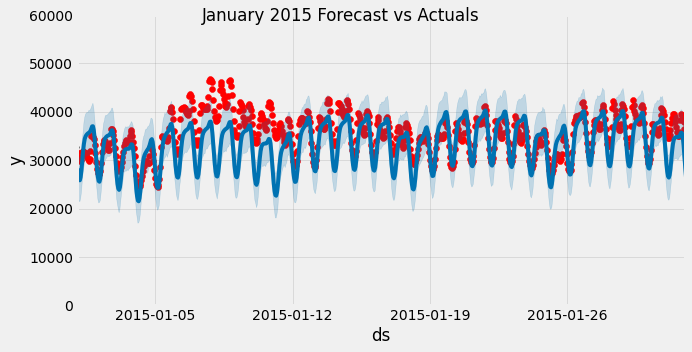

In [19]:
# plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')
fig = model.plot(pjme_test_fcst, ax=ax)
ax.set_xbound(lower='01-01-2015', upper='02-01-2015')
ax.set_ylim(0, 60000)
plot = plt.suptitle('January 2015 Forecast vs Actuals')

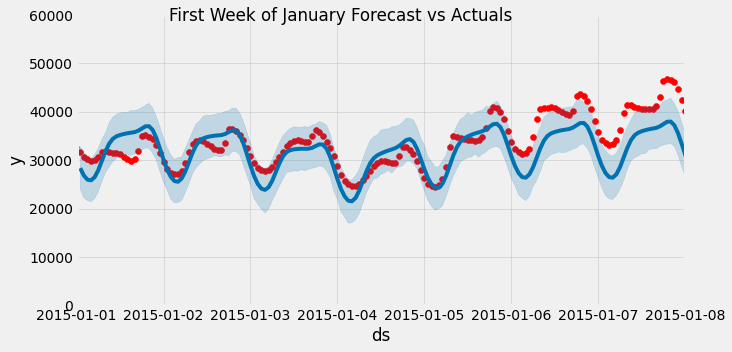

In [20]:
# plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')
fig = model.plot(pjme_test_fcst, ax=ax)
ax.set_xbound(lower='01-01-2015', upper='01-08-2015')
ax.set_ylim(0, 60000)
plot = plt.suptitle('First Week of January Forecast vs Actuals')

In [21]:
# get mse
mean_squared_error(y_true=pjme_test['PJME_MW'], y_pred=pjme_test_fcst['yhat'])

43781215.68006265

In [22]:
# get mae
mean_absolute_error(y_true=pjme_test['PJME_MW'], y_pred=pjme_test_fcst['yhat'])

5182.267565102461

In [23]:
# get mape
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_absolute_percentage_error(y_true=pjme_test['PJME_MW'], y_pred=pjme_test_fcst['yhat'])

16.511400694540228

In [26]:
# incorporate calendar data
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

cal = calendar()
train_holidays = cal.holidays(start=pjme_train.index.min(), end=pjme_train.index.max())
test_holidays = cal.holidays(start=pjme_test.index.min(), end=pjme_test.index.max())

In [27]:
# create a dataframe with holiday, ds columns
pjme['date'] = pjme.index.date
pjme['is_holiday'] = pjme.date.isin([d.date() for d in cal.holidays()])
holiday_df = pjme.loc[pjme['is_holiday']].reset_index().rename(columns={'Datetime':'ds'})
holiday_df['holiday'] = 'USFederalHoliday'
holiday_df = holiday_df.drop(['PJME_MW','date','is_holiday'], axis=1)
holiday_df['ds'] = pd.to_datetime(holiday_df['ds'])
holiday_df.head()

,ds,holiday
0,2003-01-01 00:00:00,USFederalHoliday
1,2002-12-25 01:00:00,USFederalHoliday
2,2002-12-25 02:00:00,USFederalHoliday
3,2002-12-25 03:00:00,USFederalHoliday
4,2002-12-25 04:00:00,USFederalHoliday


In [28]:
# train model with holidays
model_with_holidays = Prophet(holidays=holiday_df)
model_with_holidays.fit(pjme_train.reset_index().rename(columns={'Datetime':'ds', 'PJME_MW':'y'}))

DEBUG:cmdstanpy:input tempfile: /tmp/tmpq5q_7wsv/61k4g7hu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq5q_7wsv/moo8vcq3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84101', 'data', 'file=/tmp/tmpq5q_7wsv/61k4g7hu.json', 'init=/tmp/tmpq5q_7wsv/moo8vcq3.json', 'output', 'file=/tmp/tmpnxd40d7l/prophet_model-20220724163232.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:32:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:35:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [29]:
# predict on training set with model
pjme_test_fcst_with_hols = model_with_holidays.predict(
    df=pjme_test.reset_index().rename(columns={'Datetime':'ds'})
)

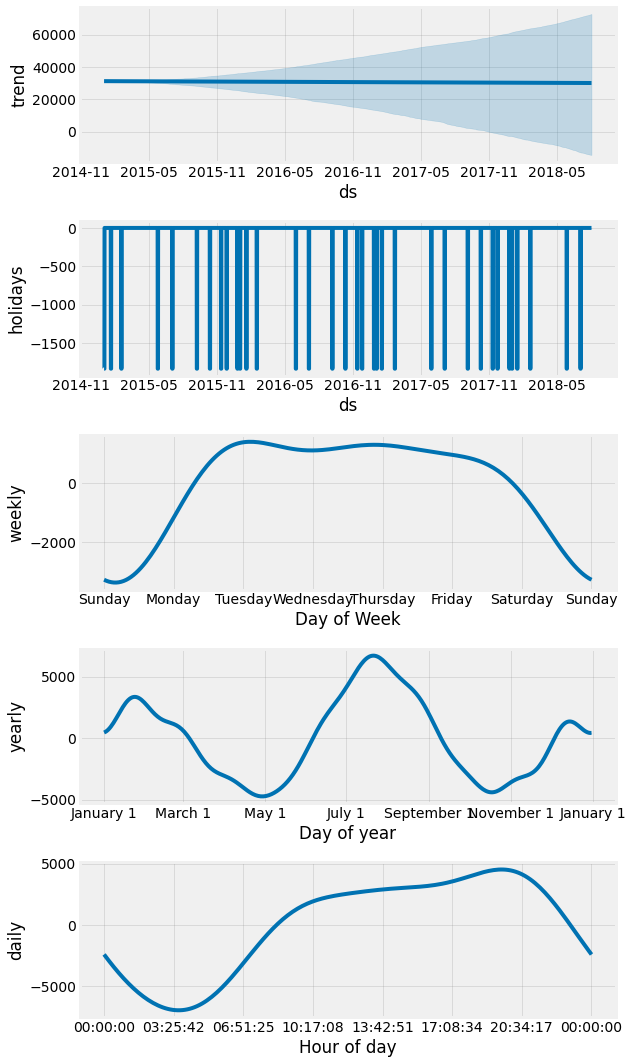

In [30]:
# plot new model component
fig2 = model_with_holidays.plot_components(pjme_test_fcst_with_hols)

In [31]:
# get mse
mean_squared_error(y_true=pjme_test['PJME_MW'], y_pred=pjme_test_fcst_with_hols['yhat'])

43885802.87711882

In [32]:
# get mae
mean_absolute_error(y_true=pjme_test['PJME_MW'], y_pred=pjme_test_fcst_with_hols['yhat'])

5189.983837626464

In [33]:
# get mape
mean_absolute_percentage_error(y_true=pjme_test['PJME_MW'], y_pred=pjme_test_fcst_with_hols['yhat'])

16.54401093989795

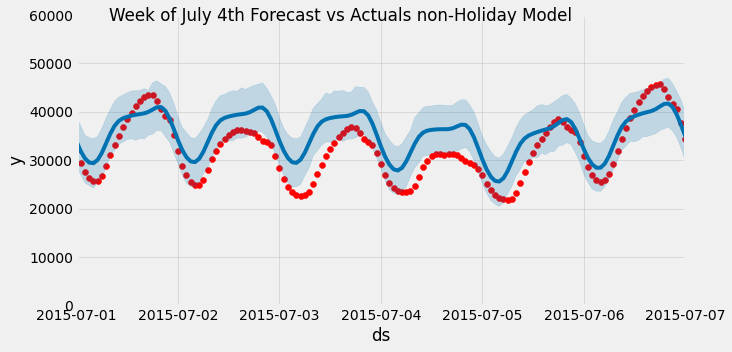

In [34]:
# plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')
fig = model.plot(pjme_test_fcst, ax=ax)
ax.set_xbound(lower='07-01-2015', upper='07-7-2015')
ax.set_ylim(0, 60000)
plot = plt.suptitle('Week of July 4th Forecast vs Actuals non-Holiday Model')

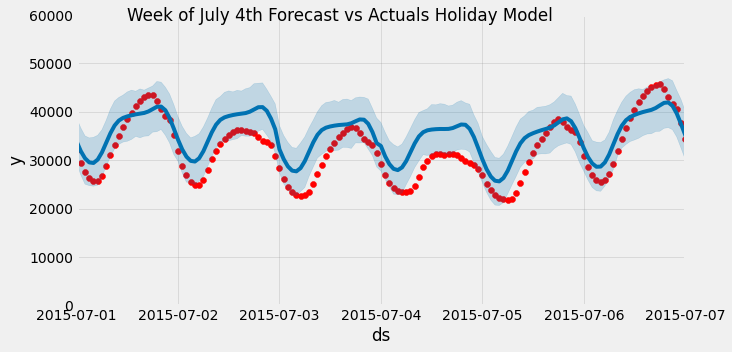

In [35]:
# plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')
fig = model.plot(pjme_test_fcst_with_hols, ax=ax)
ax.set_xbound(lower='07-01-2015', upper='07-7-2015')
ax.set_ylim(0, 60000)
plot = plt.suptitle('Week of July 4th Forecast vs Actuals Holiday Model')

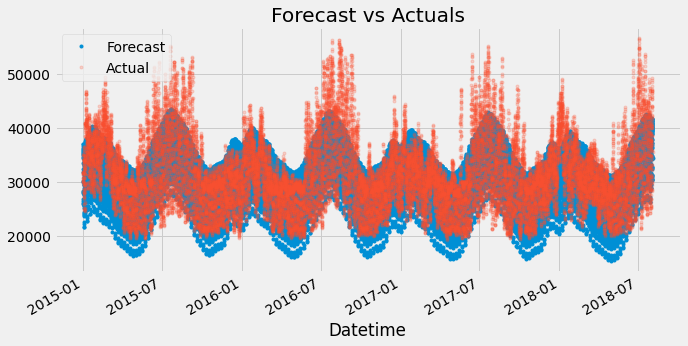

In [36]:
# plot forecast vs. actuals
ax = pjme_test_fcst.set_index('ds')['yhat'].plot(figsize=(10, 5), lw=0, style='.')
pjme_test['PJME_MW'].plot(ax=ax, style='.', lw=0, alpha=0.2)
plt.legend(['Forecast','Actual'])
plt.title('Forecast vs Actuals')
plt.show()